# Install libraly

In [1]:
# for use BigQuery API you need upgrade packages and then install required libraly
# Common Protos are common dependencies throughout the Google API ecosystem, and which are made available for use as dependencies elsewhere as BigQuery.
! pip install --upgrade googleapis-common-protos

Requirement already up-to-date: googleapis-common-protos in /usr/local/lib/python3.6/dist-packages (1.51.0)


In [2]:
! pip install google-cloud-bigquery-storage
! pip3 install pyarrow
! pip3 install fastavro

In [17]:
# for created interactive visualisation
! pip install plotly # We need install Plotly before Cufflinks
! pip install cufflinks

In [3]:
!pip show google-cloud-bigquery-storage


# for dependens
! pip3 freeze > requirements.txt

Name: google-cloud-bigquery-storage
Version: 0.7.0
Summary: BigQuery Storage API API client library
Home-page: https://github.com/GoogleCloudPlatform/google-cloud-python
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: google-api-core
Required-by: 


# Imports 

In [0]:
# print all output in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
import pandas as pd
import cufflinks as cf
import pandas_profiling
import numpy as np
from google.oauth2 import service_account
from google.cloud import *
import pyarrow as pa
import fastavro as fa



In [34]:
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [0]:
# logging need for check loading progress
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

# Define credintial and project for created and running query 

In [0]:
# initial project
project_id='bionic-tracer-254818'

In [0]:
# get credentianls and Authenticating with a Service Account
credentials = service_account.Credentials.from_service_account_file(
    'bionic-tracer-254818-38d6dd6ee2db.json')

SET 

In [0]:
query_tst = """
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
"""

In [10]:
df_iq_retail = pd.read_gbq(query_tst, 
                 project_id=project_id, 
                 credentials=credentials,   
                 use_bqstorage_api=True,   
                  configuration = {'query': {'allowLargeResult': True}},
                  dialect='standard')

Requesting query... 
Query running...
Job ID: dea5cd82-ca53-440e-812f-008316ad6340
Query done.
Cache hit.

Got 17735173 rows.

Total time taken 295.05 s.
Finished at 2020-01-26 10:36:03.


In [13]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 

In [21]:
df_iq_retail.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S08313100115,2012-10-15,3456,Quick Shop / Clear Lake,904 N 8TH ST,CLEAR LAKE,50428,POINT (-93.378772 43.142868),17,Cerro Gordo,1062300,FLAVORED RUM,35,"Bacardi U.S.A., Inc.",43198,Bacardi Torched Cherry,12,1000,10.24,15.35,2,30.70,2.0,0.53
1,S12389400073,2013-05-23,4847,Slagle Foods LeClaire,1301 EAGLE RIDGE RD,LECLAIRE,52753,POINT (-90.359813 41.587349),82,Scott,1062300,FLAVORED RUM,370,Pernod Ricard USA/Austin Nichols,42717,Malibu Coconut Rum,12,1000,10.00,14.99,2,29.98,2.0,0.53
2,S05575400017,2012-05-16,4307,Crossroads Wine and Liquor,117 IOWA AVE,DUNLAP,712-2,POINT (-95.602969 41.854728),43,Harrison,1062300,FLAVORED RUM,350,Luxco-Cleveland,44662,Lady Bligh Cherry Rum,12,1000,7.00,10.50,2,21.00,2.0,0.53
3,S03484800035,2012-01-09,4291,Fareway Stores #597 / Creston,105 E ADAMS ST,CRESTON,50801,POINT (-94.237509 40.715722),88,Union,1062300,FLAVORED RUM,370,Pernod Ricard USA/Austin Nichols,42717,Malibu Coconut Rum,12,1000,9.77,14.66,2,29.32,2.0,0.53
4,S07257000090,2012-08-22,4614,Urban Liquor,6401 DOUGLAS AVE ste 1,URBANDALE,50322,POINT (-93.705732 41.629411),77,Polk,1062300,FLAVORED RUM,370,Pernod Ricard USA/Austin Nichols,42717,Malibu Coconut Rum,12,1000,10.00,14.99,2,29.98,2.0,0.53


# Generate report for data set use libraly 
[*pandas-profiling*](https://github.com/pandas-profiling/pandas-profiling) 


---
# part I - Overview


In [0]:
profile = pandas_profiling.ProfileReport(df_iq_retail)
profile.to_file(outputfile="IOWA_liquer_data_profiling.html")

# Evaluation central position

In [0]:
# медиана, которая вычисляется как центральное значение в отсортированных значениях.
# Для двоичных, категориальных - моду
# Чтобы отобразить соотношений категорий относительно друг друга полезно графическое представление данных, например в виде столбчатых или круговых диаграмм.

# Оценка вариабельности данных


---
Самые известные оценки вариабельности － это дисперсия и стандартное отклонение, учитывающие абсолютное значение отклонений (дисперсия — это среднее квадратических отклонений, а стандартное отклонение — это квадратный корень из дисперсии).


---
Другой подход основывается на рассмотрении разброса сортированных данных (для больших наборов данных эти меры не используются, так как нужно сначала выполнить сортировку значений, что само по себе затратно). Например, оценка с помощью процентилей (также можно встретить просто центили). N-ный процентиль — это такие значения, что по крайней мере N процентов данных принимает такое значение или большее. Для того, чтобы предотвратить чувствительность к выбросам, можно отбросить значения с каждого конца. Общепринятая мера вариабельности － это разница между 25 и 75 процентилем － межквартильный размах.



# Обследование распределения данных


---
Наиболее часто используются следующие виды диаграмм: коробчатая диаграмма (или ящик с усами) и гистограммы. Ящик с усами － удобное компактное представление о выборке, позволяет на одном изображении увидеть несколько исследуемых признаков, а значит, сравнить их друг с другом. Иначе этот вид графика называется диаграмма размаха (англ. box-and-whiskers diagram or plot, box plot). Такой вид диаграммы в понятной форме показывает медиану (или, если нужно, среднее), нижний и верхний квартили, минимальное и максимальное значение выборки и выбросы. Несколько таких ящиков можно нарисовать бок о бок, чтобы визуально сравнивать одно распределение с другим; их можно располагать как горизонтально, так и вертикально. Расстояния между различными частями ящика позволяют определить степень разброса (дисперсии), асимметрии данных и выявить выбросы.


# Корреляция

In [0]:
# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [29]:
# add new column to analyze by 
df_iq_retail['month_year'] = df_iq_retail['date'].dt.to_period('M')
df_iq_retail['year'] = df_iq_retail['date'].dt.to_period('Y')

0    2012
1    2013
2    2012
3    2012
4    2012
Name: year, dtype: period[A-DEC]

# Iowa Liquor Sales by Year

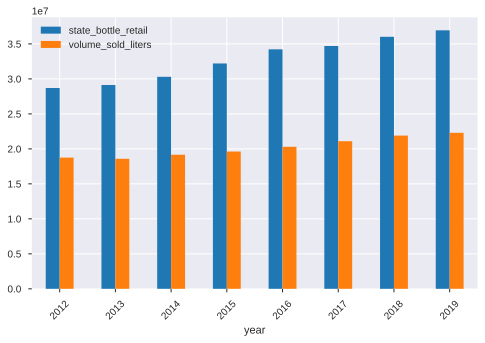

In [46]:
sales_df = df_iq_retail[['year', 'state_bottle_retail', 'volume_sold_liters']]
 
sales_df.groupby('year').sum().plot(kind='bar', rot=45) #plot(kind='bar', rot=45)

In [0]:
# drop value with n/a in 

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [48]:
missing_values_table(df_iq_retail)

Your selected dataframe has 26 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
store_location,1715161,9.7
county_number,156596,0.9
county,156594,0.9
zip_code,79836,0.5
address,79792,0.4
city,79791,0.4
category_name,24358,0.1
category,16292,0.1
state_bottle_cost,10,0.0
state_bottle_retail,10,0.0


In [50]:
# Get the columns with > 5% missing
missing_df = missing_values_table(df_iq_retail);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 5].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 26 columns.
There are 13 columns that have missing values.
We will remove 1 columns.


In [0]:

# Drop the columns
df_iq_retail_nstore = df_iq_retail.drop(columns = list(missing_columns))

# For older versions of pandas (https://github.com/pandas-dev/pandas/issues/19078)
# data = data.drop(list(missing_columns), axis = 1)

In [52]:
df_iq_retail_nstore.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,month_year,year
0,S08313100115,2012-10-15,3456,Quick Shop / Clear Lake,904 N 8TH ST,CLEAR LAKE,50428,17,Cerro Gordo,1062300,FLAVORED RUM,35,"Bacardi U.S.A., Inc.",43198,Bacardi Torched Cherry,12,1000,10.24,15.35,2,30.70,2.0,0.53,2012-10,2012
1,S12389400073,2013-05-23,4847,Slagle Foods LeClaire,1301 EAGLE RIDGE RD,LECLAIRE,52753,82,Scott,1062300,FLAVORED RUM,370,Pernod Ricard USA/Austin Nichols,42717,Malibu Coconut Rum,12,1000,10.00,14.99,2,29.98,2.0,0.53,2013-05,2013
2,S05575400017,2012-05-16,4307,Crossroads Wine and Liquor,117 IOWA AVE,DUNLAP,712-2,43,Harrison,1062300,FLAVORED RUM,350,Luxco-Cleveland,44662,Lady Bligh Cherry Rum,12,1000,7.00,10.50,2,21.00,2.0,0.53,2012-05,2012
3,S03484800035,2012-01-09,4291,Fareway Stores #597 / Creston,105 E ADAMS ST,CRESTON,50801,88,Union,1062300,FLAVORED RUM,370,Pernod Ricard USA/Austin Nichols,42717,Malibu Coconut Rum,12,1000,9.77,14.66,2,29.32,2.0,0.53,2012-01,2012
4,S07257000090,2012-08-22,4614,Urban Liquor,6401 DOUGLAS AVE ste 1,URBANDALE,50322,77,Polk,1062300,FLAVORED RUM,370,Pernod Ricard USA/Austin Nichols,42717,Malibu Coconut Rum,12,1000,10.00,14.99,2,29.98,2.0,0.53,2012-08,2012
